In [ ]:
!pip3 install --upgrade tensorflow-model-optimization
!pip3 install mat4py

from mat4py import loadmat
import numpy as np
import tensorflow as tf
import tensorflow_model_optimization as tfmot
import matplotlib.pyplot as plt
import json
import tempfile
from google.colab import drive
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm
import matplotlib.ticker as tick


print(tf.__version__)

drive.mount('/content/drive')
%cd /content/drive/My Drive/CGM_prediction_data

     |████████████████████████████████| 174kB 2.8MB/s 
2.3.0
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/CGM_prediction_data


# Data pre-processing

In [ ]:
def downscale(data, resolution):

    # 10 min resolution.. (data.shape[0], 3, 1440) -> (data.shape[0], 10, 3, 144).. breaks one 3,1440 length trajectory into ten 3,144 length trajectories
    # Use ~12 timesteps -> 2-5 timesteps (Use ~2 hours to predict 20-50 mins)

    return np.mean(data.reshape(data.shape[0], data.shape[1], int(data.shape[2]/resolution), resolution), axis=3)



def process_data(aligned_data, time_horizon, ph):

    # 10 min resolution.. breaks each (3,144) trajectory into (144-ph-time_horizon,3,time_horizon) samples

    data = np.zeros((aligned_data.shape[0] * (aligned_data.shape[2]-ph-time_horizon), aligned_data.shape[1], time_horizon))
    label = np.zeros((aligned_data.shape[0] * (aligned_data.shape[2]-ph-time_horizon), ph))

    count = 0
    for i in range(aligned_data.shape[0]): # for each sample
        for j in range(aligned_data.shape[2]-ph-time_horizon): # TH length sliding window across trajectory
                data[count] = aligned_data[i,:,j:j+time_horizon]
                label[count] = aligned_data[i,0,j+time_horizon:j+time_horizon+ph]
                count+=1     

    return data, label


def load_mpc(time_horizon, ph, resolution, batch): # int, int, int, bool
    
    # Load train data
    g = np.loadtxt('glucose_readings_train.csv', delimiter=',')
    c = np.loadtxt('meals_carbs_train.csv', delimiter=',') 
    it = np.loadtxt('insulin_therapy_train.csv', delimiter=',')

    # Load test data
    g_ = np.loadtxt('glucose_readings_test.csv', delimiter=',')
    c_ = np.loadtxt('meals_carbs_test.csv', delimiter=',')
    it_ = np.loadtxt('insulin_therapy_test.csv', delimiter=',')

    # Time align train & test data
    aligned_train_data = downscale(np.array([(g[i,:], c[i,:], it[i,:]) for i in range(g.shape[0])]), resolution)
    aligned_test_data = downscale(np.array([(g_[i,:], c_[i,:], it_[i,:]) for i in range(g_.shape[0])]), resolution)
    print(aligned_train_data.shape)

    # Break time aligned data into train & test samples
    if batch:
        train_data, train_label = process_data(aligned_train_data, time_horizon, ph)
        test_data, test_label = process_data(aligned_test_data, time_horizon, ph)
    
        return np.swapaxes(train_data,1,2), train_label, np.swapaxes(test_data,1,2), test_label
      
    else:

        return aligned_train_data, aligned_test_data

def load_uva(time_horizon, ph, resolution, batch):

    data = loadmat('uva/sim_results.mat')
    train_data = np.zeros((231,3,1440))
    test_data = np.zeros((99,3,1440))

    # Separate train and test sets.. last 3 records of each patient will be used for testing
    count_train = 0
    count_test = 0
    for i in range(33):
        for j in range(10):

            if j>=7:
                test_data[count_test,0,:] = np.asarray(data['data']['results']['sensor'][count_test+count_train]['signals']['values']).flatten()[:1440]
                test_data[count_test,1,:] = np.asarray(data['data']['results']['CHO'][count_test+count_train]['signals']['values']).flatten()[:1440]
                test_data[count_test,2,:] = np.asarray(data['data']['results']['BOLUS'][count_test+count_train]['signals']['values']).flatten()[:1440] + np.asarray(data['data']['results']['BASAL'][i]['signals']['values']).flatten()[:1440]
                count_test+=1
            else:

                train_data[count_train,0,:] = np.asarray(data['data']['results']['sensor'][count_test+count_train]['signals']['values']).flatten()[:1440]
                train_data[count_train,1,:] = np.asarray(data['data']['results']['CHO'][count_test+count_train]['signals']['values']).flatten()[:1440]
                train_data[count_train,2,:] = np.asarray(data['data']['results']['BOLUS'][count_test+count_train]['signals']['values']).flatten()[:1440] + np.asarray(data['data']['results']['BASAL'][i]['signals']['values']).flatten()[:1440]
                count_train+=1

    train_data = downscale(train_data, resolution)
    test_data = downscale(test_data, resolution)

    if batch: 
        train_data, train_label = process_data(train_data, time_horizon, ph)
        test_data, test_label = process_data(test_data, time_horizon, ph)
    
        return np.swapaxes(train_data,1,2)*0.0555, train_label*0.0555, np.swapaxes(test_data,1,2)*0.0555, test_label*0.0555 # convert to mmol/L

    else:
        
        return train_data, test_data

# Monte Carlo dropout

In [ ]:
def sampling(model, test_data, test_label, samples):

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])

    mc_ensemble = np.zeros(test_label.shape)
    mc_mse = np.zeros(samples)
    predictions = np.zeros((samples, test_label.shape[0], test_label.shape[1])) # (mc_samples, test samples, ph)

    for j in tqdm(range(0,samples)):

        sample_predictions = model.predict(test_data, batch_size=1000)
        predictions[j,:,:] = sample_predictions
        mc_mse[j] = mean_squared_error(sample_predictions, test_label)
        mc_ensemble = [a+b for a,b in zip(mc_ensemble, sample_predictions)]
 

    return mean_squared_error([i/samples for i in mc_ensemble], test_label), mc_mse, predictions

def credible_interval(predictions, alpha):

    # Sort predictions from smallest to largest
    predictions = np.sort(predictions, axis=0)
#    print(predictions.shape)
    # Upper & lower bounds
    ci = np.zeros((predictions.shape[1], 2))
#    print(ci.shape)
#    print(np.floor(predictions.shape[0]*(alpha/2)))
    ci[:,0] = predictions[int(np.floor(predictions.shape[0]*(alpha/2))),:]
    ci[:,1] = predictions[int(-np.floor(predictions.shape[0]*(alpha/2))),:]

    return ci


# MPC Results

## Bidirectional LSTM

(756, 3, 144)


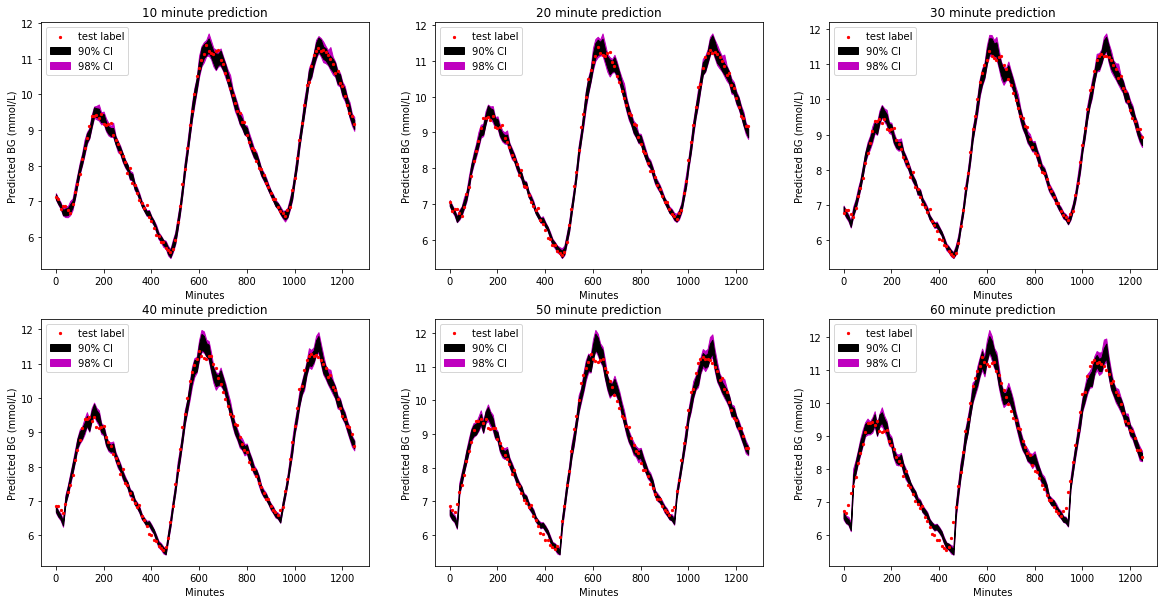

In [ ]:
PH = 6
TIME_HORIZON = 12
RESOLUTION = 10
SAMPLES = 100
BATCH = True

# Load data & model

_, __, test_data, test_label = load_mpc(TIME_HORIZON, PH, RESOLUTION, BATCH)

bilstm = tf.keras.models.load_model('saved_models/mpc_guided_bilstm.h5', compile=False)
bilstm_ensemble, bilstm_mse, bilstm_pred = sampling(bilstm, test_data, test_label, SAMPLES)

# Construct CI for 10 min prediction

fig, axes = plt.subplots(2,3)
plt.rcParams["legend.loc"] = 'upper left'
plt.rcParams["figure.figsize"] = (20,10)

bilstm_CI_10mins_90percent = credible_interval(bilstm_pred[:,:,0],alpha=0.1)
bilstm_CI_10mins_98percent = credible_interval(bilstm_pred[:,:,0],alpha=0.02)

axes[0,0].scatter(np.arange(144-TIME_HORIZON-PH)*10, test_label[:144-TIME_HORIZON-PH,0], s=5, c='r', marker='o', label='test label', zorder=10)
axes[0,0].fill_between(np.arange(144-TIME_HORIZON-PH)*10, bilstm_CI_10mins_90percent[:144-TIME_HORIZON-PH,1], bilstm_CI_10mins_90percent[:144-TIME_HORIZON-PH,0], color='k', label='90% CI', zorder=5)
axes[0,0].fill_between(np.arange(144-TIME_HORIZON-PH)*10, bilstm_CI_10mins_98percent[:144-TIME_HORIZON-PH,1],bilstm_CI_10mins_98percent[:144-TIME_HORIZON-PH,0], color='m', label='98% CI', zorder=0)
axes[0,0].set_xlabel('Minutes')
axes[0,0].set_ylabel('Predicted BG (mmol/L)')
axes[0,0].title.set_text('10 minute prediction')
axes[0,0].legend()

# Construct CI for 20 min prediction

bilstm_CI_20mins_90percent = credible_interval(bilstm_pred[:,:,1],alpha=0.1)
bilstm_CI_20mins_98percent = credible_interval(bilstm_pred[:,:,1],alpha=0.02)

axes[0,1].scatter(np.arange(144-TIME_HORIZON-PH)*10, test_label[:144-TIME_HORIZON-PH,1], s=5, c='r', marker='o', label='test label', zorder=10)
axes[0,1].fill_between(np.arange(144-TIME_HORIZON-PH)*10, bilstm_CI_20mins_90percent[:144-TIME_HORIZON-PH,1], bilstm_CI_20mins_90percent[:144-TIME_HORIZON-PH,0], color='k', label='90% CI', zorder=5)
axes[0,1].fill_between(np.arange(144-TIME_HORIZON-PH)*10, bilstm_CI_20mins_98percent[:144-TIME_HORIZON-PH,1],bilstm_CI_20mins_98percent[:144-TIME_HORIZON-PH,0], color='m', label='98% CI', zorder=0)
axes[0,1].set_xlabel('Minutes')
axes[0,1].set_ylabel('Predicted BG (mmol/L)')
axes[0,1].title.set_text('20 minute prediction')
axes[0,1].legend()

# Construct CI for 30 min prediction

bilstm_CI_30mins_90percent = credible_interval(bilstm_pred[:,:,2],alpha=0.1)
bilstm_CI_30mins_98percent = credible_interval(bilstm_pred[:,:,2],alpha=0.02)

axes[0,2].scatter(np.arange(144-TIME_HORIZON-PH)*10, test_label[:144-TIME_HORIZON-PH,2], s=5, c='r', marker='o', label='test label', zorder=10)
axes[0,2].fill_between(np.arange(144-TIME_HORIZON-PH)*10, bilstm_CI_30mins_90percent[:144-TIME_HORIZON-PH,1], bilstm_CI_30mins_90percent[:144-TIME_HORIZON-PH,0], color='k', label='90% CI', zorder=5)
axes[0,2].fill_between(np.arange(144-TIME_HORIZON-PH)*10, bilstm_CI_30mins_98percent[:144-TIME_HORIZON-PH,1], bilstm_CI_30mins_98percent[:144-TIME_HORIZON-PH,0], color='m', label='98% CI', zorder=0)
axes[0,2].set_xlabel('Minutes')
axes[0,2].set_ylabel('Predicted BG (mmol/L)')
axes[0,2].title.set_text('30 minute prediction')
axes[0,2].legend()

# Construct CI for 40 min prediction

bilstm_CI_40mins_90percent = credible_interval(bilstm_pred[:,:,3],alpha=0.1)
bilstm_CI_40mins_98percent = credible_interval(bilstm_pred[:,:,3],alpha=0.02)

axes[1,0].scatter(np.arange(144-TIME_HORIZON-PH)*10, test_label[:144-TIME_HORIZON-PH,3], s=5, c='r', marker='o', label='test label', zorder=10)
axes[1,0].fill_between(np.arange(144-TIME_HORIZON-PH)*10, bilstm_CI_40mins_90percent[:144-TIME_HORIZON-PH,1], bilstm_CI_40mins_90percent[:144-TIME_HORIZON-PH,0], color='k', label='90% CI', zorder=5)
axes[1,0].fill_between(np.arange(144-TIME_HORIZON-PH)*10, bilstm_CI_40mins_98percent[:144-TIME_HORIZON-PH,1], bilstm_CI_40mins_98percent[:144-TIME_HORIZON-PH,0], color='m', label='98% CI', zorder=0)
axes[1,0].set_xlabel('Minutes')
axes[1,0].set_ylabel('Predicted BG (mmol/L)')
axes[1,0].title.set_text('40 minute prediction')
axes[1,0].legend()

# Construct CI for 50 min prediction

bilstm_CI_50mins_90percent = credible_interval(bilstm_pred[:,:,4],alpha=0.1)
bilstm_CI_50mins_98percent = credible_interval(bilstm_pred[:,:,4],alpha=0.02)

axes[1,1].scatter(np.arange(144-TIME_HORIZON-PH)*10, test_label[:144-TIME_HORIZON-PH,4], s=5, c='r', marker='o', label='test label', zorder=10)
axes[1,1].fill_between(np.arange(144-TIME_HORIZON-PH)*10, bilstm_CI_50mins_90percent[:144-TIME_HORIZON-PH,1], bilstm_CI_50mins_90percent[:144-TIME_HORIZON-PH,0], color='k', label='90% CI', zorder=5)
axes[1,1].fill_between(np.arange(144-TIME_HORIZON-PH)*10, bilstm_CI_50mins_98percent[:144-TIME_HORIZON-PH,1], bilstm_CI_50mins_98percent[:144-TIME_HORIZON-PH,0], color='m', label='98% CI', zorder=0)
axes[1,1].set_xlabel('Minutes')
axes[1,1].set_ylabel('Predicted BG (mmol/L)')
axes[1,1].title.set_text('50 minute prediction')
axes[1,1].legend()

# Construct CI for 60 min prediction

bilstm_CI_60mins_90percent = credible_interval(bilstm_pred[:,:,5],alpha=0.1)
bilstm_CI_60mins_98percent = credible_interval(bilstm_pred[:,:,5],alpha=0.02)

axes[1,2].scatter(np.arange(144-TIME_HORIZON-PH)*10, test_label[:144-TIME_HORIZON-PH,5], s=5, c='r', marker='o', label='test label', zorder=10)
axes[1,2].fill_between(np.arange(144-TIME_HORIZON-PH)*10, bilstm_CI_60mins_90percent[:144-TIME_HORIZON-PH,1], bilstm_CI_60mins_90percent[:144-TIME_HORIZON-PH,0], color='k', label='90% CI', zorder=5)
axes[1,2].fill_between(np.arange(144-TIME_HORIZON-PH)*10, bilstm_CI_60mins_98percent[:144-TIME_HORIZON-PH,1], bilstm_CI_60mins_98percent[:144-TIME_HORIZON-PH,0], color='m', label='98% CI', zorder=0)
axes[1,2].set_xlabel('Minutes')
axes[1,2].set_ylabel('Predicted BG (mmol/L)')
axes[1,2].title.set_text('60 minute prediction')
axes[1,2].legend()

#fig.suptitle('Figure 15: Bidirectional LSTM Credible Intervals', fontsize='x-large')
plt.show()

## LSTM

(756, 3, 144)


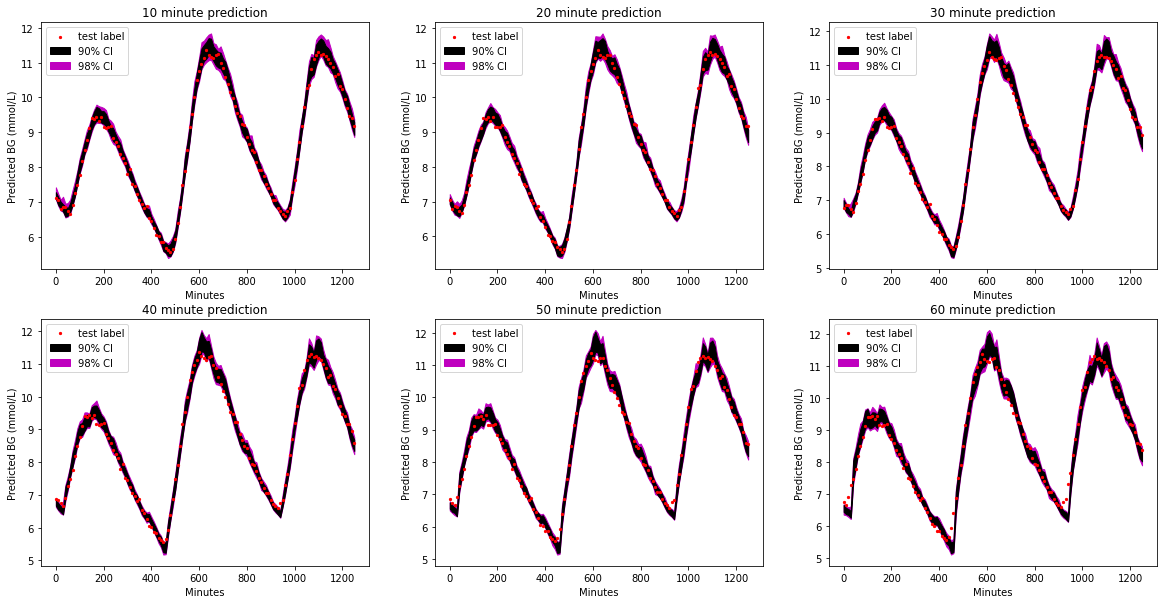

In [ ]:
PH = 6
TIME_HORIZON = 12
RESOLUTION = 10
SAMPLES = 100
BATCH = True

# Load data & model
plt.rcParams["legend.loc"] = 'best'


_, __, test_data, test_label = load_mpc(TIME_HORIZON, PH, RESOLUTION, BATCH)

lstm = tf.keras.models.load_model('saved_models/mpc_guided_lstm.h5', compile=False)
lstm_ensemble, lstm_mse, lstm_pred = sampling(lstm, test_data, test_label, SAMPLES)

# Construct CI for 10 min prediction

fig, axes = plt.subplots(2,3)
plt.rcParams["figure.figsize"] = (20,10)

lstm_CI_10mins_90percent = credible_interval(lstm_pred[:,:,0],alpha=0.1)
lstm_CI_10mins_98percent = credible_interval(lstm_pred[:,:,0],alpha=0.02)

axes[0,0].scatter(np.arange(144-TIME_HORIZON-PH)*10, test_label[:144-TIME_HORIZON-PH,0], s=5, c='r', marker='o', label='test label', zorder=10)
axes[0,0].fill_between(np.arange(144-TIME_HORIZON-PH)*10, lstm_CI_10mins_90percent[:144-TIME_HORIZON-PH,1], lstm_CI_10mins_90percent[:144-TIME_HORIZON-PH,0], color='k', label='90% CI', zorder=5)
axes[0,0].fill_between(np.arange(144-TIME_HORIZON-PH)*10, lstm_CI_10mins_98percent[:144-TIME_HORIZON-PH,1], lstm_CI_10mins_98percent[:144-TIME_HORIZON-PH,0], color='m', label='98% CI', zorder=0)
axes[0,0].set_xlabel('Minutes')
axes[0,0].set_ylabel('Predicted BG (mmol/L)')
axes[0,0].title.set_text('10 minute prediction')
axes[0,0].legend()

# Construct CI for 20 min prediction

lstm_CI_20mins_90percent = credible_interval(lstm_pred[:,:,1],alpha=0.1)
lstm_CI_20mins_98percent = credible_interval(lstm_pred[:,:,1],alpha=0.02)

axes[0,1].scatter(np.arange(144-TIME_HORIZON-PH)*10, test_label[:144-TIME_HORIZON-PH,1], s=5, c='r', marker='o', label='test label', zorder=10)
axes[0,1].fill_between(np.arange(144-TIME_HORIZON-PH)*10, lstm_CI_20mins_90percent[:144-TIME_HORIZON-PH,1], lstm_CI_20mins_90percent[:144-TIME_HORIZON-PH,0], color='k', label='90% CI', zorder=5)
axes[0,1].fill_between(np.arange(144-TIME_HORIZON-PH)*10, lstm_CI_20mins_98percent[:144-TIME_HORIZON-PH,1], lstm_CI_20mins_98percent[:144-TIME_HORIZON-PH,0], color='m', label='98% CI', zorder=0)
axes[0,1].set_xlabel('Minutes')
axes[0,1].set_ylabel('Predicted BG (mmol/L)')
axes[0,1].title.set_text('20 minute prediction')
axes[0,1].legend()

# Construct CI for 30 min prediction

lstm_CI_30mins_90percent = credible_interval(lstm_pred[:,:,2],alpha=0.1)
lstm_CI_30mins_98percent = credible_interval(lstm_pred[:,:,2],alpha=0.02)

axes[0,2].scatter(np.arange(144-TIME_HORIZON-PH)*10, test_label[:144-TIME_HORIZON-PH,2], s=5, c='r', marker='o', label='test label', zorder=10)
axes[0,2].fill_between(np.arange(144-TIME_HORIZON-PH)*10, lstm_CI_30mins_90percent[:144-TIME_HORIZON-PH,1], lstm_CI_30mins_90percent[:144-TIME_HORIZON-PH,0], color='k', label='90% CI', zorder=5)
axes[0,2].fill_between(np.arange(144-TIME_HORIZON-PH)*10, lstm_CI_30mins_98percent[:144-TIME_HORIZON-PH,1], lstm_CI_30mins_98percent[:144-TIME_HORIZON-PH,0], color='m', label='98% CI', zorder=0)
axes[0,2].set_xlabel('Minutes')
axes[0,2].set_ylabel('Predicted BG (mmol/L)')
axes[0,2].title.set_text('30 minute prediction')
axes[0,2].legend()

# Construct CI for 40 min prediction

lstm_CI_40mins_90percent = credible_interval(lstm_pred[:,:,3],alpha=0.1)
lstm_CI_40mins_98percent = credible_interval(lstm_pred[:,:,3],alpha=0.02)

axes[1,0].scatter(np.arange(144-TIME_HORIZON-PH)*10, test_label[:144-TIME_HORIZON-PH,3], s=5, c='r', marker='o', label='test label', zorder=10)
axes[1,0].fill_between(np.arange(144-TIME_HORIZON-PH)*10, lstm_CI_40mins_90percent[:144-TIME_HORIZON-PH,1], lstm_CI_40mins_90percent[:144-TIME_HORIZON-PH,0], color='k', label='90% CI', zorder=5)
axes[1,0].fill_between(np.arange(144-TIME_HORIZON-PH)*10, lstm_CI_40mins_98percent[:144-TIME_HORIZON-PH,1], lstm_CI_40mins_98percent[:144-TIME_HORIZON-PH,0], color='m', label='98% CI', zorder=0)
axes[1,0].set_xlabel('Minutes')
axes[1,0].set_ylabel('Predicted BG (mmol/L)')
axes[1,0].title.set_text('40 minute prediction')
axes[1,0].legend()

# Construct CI for 50 min prediction

lstm_CI_50mins_90percent = credible_interval(lstm_pred[:,:,4],alpha=0.1)
lstm_CI_50mins_98percent = credible_interval(lstm_pred[:,:,4],alpha=0.02)

axes[1,1].scatter(np.arange(144-TIME_HORIZON-PH)*10, test_label[:144-TIME_HORIZON-PH,4], s=5, c='r', marker='o', label='test label', zorder=10)
axes[1,1].fill_between(np.arange(144-TIME_HORIZON-PH)*10, lstm_CI_50mins_90percent[:144-TIME_HORIZON-PH,1], lstm_CI_50mins_90percent[:144-TIME_HORIZON-PH,0], color='k', label='90% CI', zorder=5)
axes[1,1].fill_between(np.arange(144-TIME_HORIZON-PH)*10, lstm_CI_50mins_98percent[:144-TIME_HORIZON-PH,1], lstm_CI_50mins_98percent[:144-TIME_HORIZON-PH,0], color='m', label='98% CI', zorder=0)
axes[1,1].set_xlabel('Minutes')
axes[1,1].set_ylabel('Predicted BG (mmol/L)')
axes[1,1].title.set_text('50 minute prediction')
axes[1,1].legend()

# Construct CI for 60 min prediction

lstm_CI_60mins_90percent = credible_interval(lstm_pred[:,:,5],alpha=0.1)
lstm_CI_60mins_98percent = credible_interval(lstm_pred[:,:,5],alpha=0.02)

axes[1,2].scatter(np.arange(144-TIME_HORIZON-PH)*10, test_label[:144-TIME_HORIZON-PH,5], s=5, c='r', marker='o', label='test label', zorder=10)
axes[1,2].fill_between(np.arange(144-TIME_HORIZON-PH)*10, lstm_CI_60mins_90percent[:144-TIME_HORIZON-PH,1], lstm_CI_60mins_90percent[:144-TIME_HORIZON-PH,0], color='k', label='90% CI', zorder=5)
axes[1,2].fill_between(np.arange(144-TIME_HORIZON-PH)*10, lstm_CI_60mins_98percent[:144-TIME_HORIZON-PH,1], lstm_CI_60mins_98percent[:144-TIME_HORIZON-PH,0], color='m', label='98% CI', zorder=0)
axes[1,2].set_xlabel('Minutes')
axes[1,2].set_ylabel('Predicted BG (mmol/L)')
axes[1,2].title.set_text('60 minute prediction')
axes[1,2].legend()

#fig.suptitle('Figure 13: LSTM Credible Intervals', fontsize='x-large')
plt.show()

## CRNN

(756, 3, 144)


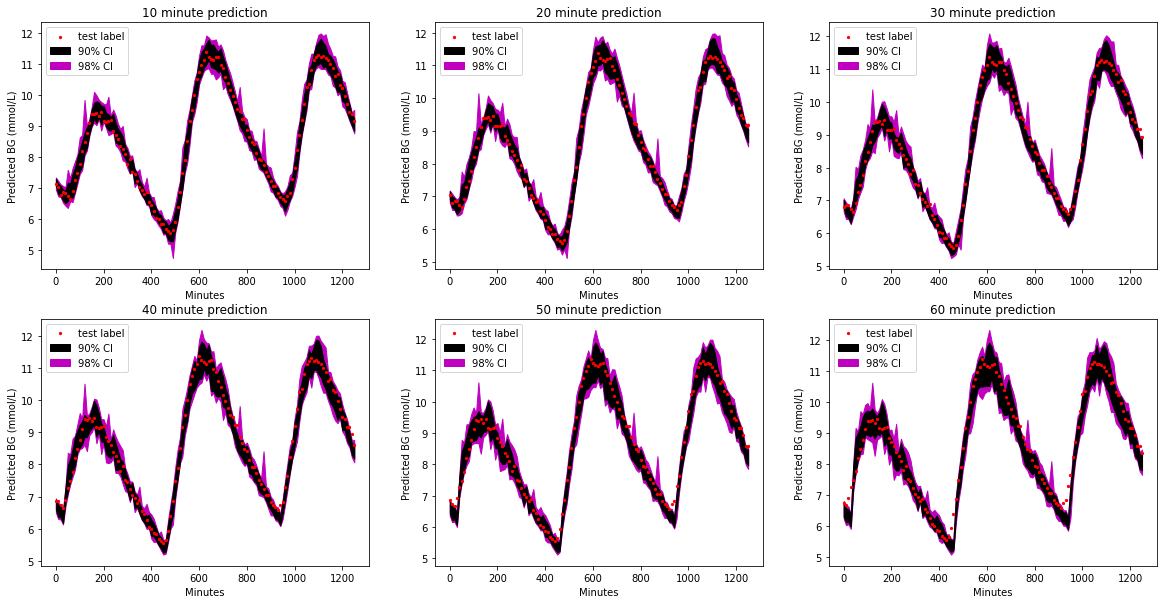

In [ ]:
PH = 6
TIME_HORIZON = 12
RESOLUTION = 10
SAMPLES = 100
BATCH = True

# Load data & model

_, __, test_data, test_label = load_mpc(TIME_HORIZON, PH, RESOLUTION, BATCH)

crnn = tf.keras.models.load_model('saved_models/mpc_guided_crnn.h5', compile=False)
crnn_ensemble, crnn_mse, crnn_pred = sampling(crnn, test_data, test_label, SAMPLES)

# Construct CI for 10 min prediction

fig, axes = plt.subplots(2,3)
plt.rcParams["figure.figsize"] = (20,10)

crnn_CI_10mins_90percent = credible_interval(crnn_pred[:,:,0],alpha=0.1)
crnn_CI_10mins_98percent = credible_interval(crnn_pred[:,:,0],alpha=0.02)

axes[0,0].scatter(np.arange(144-TIME_HORIZON-PH)*10, test_label[:144-TIME_HORIZON-PH,0], s=5, c='r', marker='o', label='test label', zorder=10)
axes[0,0].fill_between(np.arange(144-TIME_HORIZON-PH)*10, crnn_CI_10mins_90percent[:144-TIME_HORIZON-PH,1], crnn_CI_10mins_90percent[:144-TIME_HORIZON-PH,0], color='k', label='90% CI', zorder=5)
axes[0,0].fill_between(np.arange(144-TIME_HORIZON-PH)*10, crnn_CI_10mins_98percent[:144-TIME_HORIZON-PH,1], crnn_CI_10mins_98percent[:144-TIME_HORIZON-PH,0], color='m', label='98% CI', zorder=0)
axes[0,0].set_xlabel('Minutes')
axes[0,0].set_ylabel('Predicted BG (mmol/L)')
axes[0,0].title.set_text('10 minute prediction')
axes[0,0].legend()

# Construct CI for 20 min prediction

crnn_CI_20mins_90percent = credible_interval(crnn_pred[:,:,1],alpha=0.1)
crnn_CI_20mins_98percent = credible_interval(crnn_pred[:,:,1],alpha=0.02)

axes[0,1].scatter(np.arange(144-TIME_HORIZON-PH)*10, test_label[:144-TIME_HORIZON-PH,1], s=5, c='r', marker='o', label='test label', zorder=10)
axes[0,1].fill_between(np.arange(144-TIME_HORIZON-PH)*10, crnn_CI_20mins_90percent[:144-TIME_HORIZON-PH,1], crnn_CI_20mins_90percent[:144-TIME_HORIZON-PH,0], color='k', label='90% CI', zorder=5)
axes[0,1].fill_between(np.arange(144-TIME_HORIZON-PH)*10, crnn_CI_20mins_98percent[:144-TIME_HORIZON-PH,1], crnn_CI_20mins_98percent[:144-TIME_HORIZON-PH,0], color='m', label='98% CI', zorder=0)
axes[0,1].set_xlabel('Minutes')
axes[0,1].set_ylabel('Predicted BG (mmol/L)')
axes[0,1].title.set_text('20 minute prediction')
axes[0,1].legend()

# Construct CI for 30 min prediction

crnn_CI_30mins_90percent = credible_interval(crnn_pred[:,:,2],alpha=0.1)
crnn_CI_30mins_98percent = credible_interval(crnn_pred[:,:,2],alpha=0.02)

axes[0,2].scatter(np.arange(144-TIME_HORIZON-PH)*10, test_label[:144-TIME_HORIZON-PH,2], s=5, c='r', marker='o', label='test label', zorder=10)
axes[0,2].fill_between(np.arange(144-TIME_HORIZON-PH)*10, crnn_CI_30mins_90percent[:144-TIME_HORIZON-PH,1], crnn_CI_30mins_90percent[:144-TIME_HORIZON-PH,0], color='k', label='90% CI', zorder=5)
axes[0,2].fill_between(np.arange(144-TIME_HORIZON-PH)*10, crnn_CI_30mins_98percent[:144-TIME_HORIZON-PH,1], crnn_CI_30mins_98percent[:144-TIME_HORIZON-PH,0], color='m', label='98% CI', zorder=0)
axes[0,2].set_xlabel('Minutes')
axes[0,2].set_ylabel('Predicted BG (mmol/L)')
axes[0,2].title.set_text('30 minute prediction')
axes[0,2].legend()

# Construct CI for 40 min prediction

crnn_CI_40mins_90percent = credible_interval(crnn_pred[:,:,3],alpha=0.1)
crnn_CI_40mins_98percent = credible_interval(crnn_pred[:,:,3],alpha=0.02)

axes[1,0].scatter(np.arange(144-TIME_HORIZON-PH)*10, test_label[:144-TIME_HORIZON-PH,3], s=5, c='r', marker='o', label='test label', zorder=10)
axes[1,0].fill_between(np.arange(144-TIME_HORIZON-PH)*10, crnn_CI_40mins_90percent[:144-TIME_HORIZON-PH,1], crnn_CI_40mins_90percent[:144-TIME_HORIZON-PH,0], color='k', label='90% CI', zorder=5)
axes[1,0].fill_between(np.arange(144-TIME_HORIZON-PH)*10, crnn_CI_40mins_98percent[:144-TIME_HORIZON-PH,1], crnn_CI_40mins_98percent[:144-TIME_HORIZON-PH,0], color='m', label='98% CI', zorder=0)
axes[1,0].set_xlabel('Minutes')
axes[1,0].set_ylabel('Predicted BG (mmol/L)')
axes[1,0].title.set_text('40 minute prediction')
axes[1,0].legend()

# Construct CI for 50 min prediction

crnn_CI_50mins_90percent = credible_interval(crnn_pred[:,:,4],alpha=0.1)
crnn_CI_50mins_98percent = credible_interval(crnn_pred[:,:,4],alpha=0.02)

axes[1,1].scatter(np.arange(144-TIME_HORIZON-PH)*10, test_label[:144-TIME_HORIZON-PH,4], s=5, c='r', marker='o', label='test label', zorder=10)
axes[1,1].fill_between(np.arange(144-TIME_HORIZON-PH)*10, crnn_CI_50mins_90percent[:144-TIME_HORIZON-PH,1], crnn_CI_50mins_90percent[:144-TIME_HORIZON-PH,0], color='k', label='90% CI', zorder=5)
axes[1,1].fill_between(np.arange(144-TIME_HORIZON-PH)*10, crnn_CI_50mins_98percent[:144-TIME_HORIZON-PH,1], crnn_CI_50mins_98percent[:144-TIME_HORIZON-PH,0], color='m', label='98% CI', zorder=0)
axes[1,1].set_xlabel('Minutes')
axes[1,1].set_ylabel('Predicted BG (mmol/L)')
axes[1,1].title.set_text('50 minute prediction')
axes[1,1].legend()

# Construct CI for 60 min prediction

crnn_CI_60mins_90percent = credible_interval(crnn_pred[:,:,5],alpha=0.1)
crnn_CI_60mins_98percent = credible_interval(crnn_pred[:,:,5],alpha=0.02)

axes[1,2].scatter(np.arange(144-TIME_HORIZON-PH)*10, test_label[:144-TIME_HORIZON-PH,5], s=5, c='r', marker='o', label='test label', zorder=10)
axes[1,2].fill_between(np.arange(144-TIME_HORIZON-PH)*10, crnn_CI_60mins_90percent[:144-TIME_HORIZON-PH,1], crnn_CI_60mins_90percent[:144-TIME_HORIZON-PH,0], color='k', label='90% CI', zorder=5)
axes[1,2].fill_between(np.arange(144-TIME_HORIZON-PH)*10, crnn_CI_60mins_98percent[:144-TIME_HORIZON-PH,1], crnn_CI_60mins_98percent[:144-TIME_HORIZON-PH,0], color='m', label='98% CI', zorder=0)
axes[1,2].set_xlabel('Minutes')
axes[1,2].set_ylabel('Predicted BG (mmol/L)')
axes[1,2].title.set_text('60 minute prediction')
axes[1,2].legend()

#fig.suptitle('Figure 14: CRNN Credible Intervals', fontsize='x-large')
plt.show()

## Average intervals

In [ ]:
PH = 6
TIME_HORIZON = 12
RESOLUTION = 10
SAMPLES = 100
BATCH = True

# Load data & model

_, __, test_data, test_label = load_mpc(TIME_HORIZON, PH, RESOLUTION, BATCH)

bilstm = tf.keras.models.load_model('saved_models/mpc_guided_bilstm.h5', compile=False)
bilstm_ensemble, bilstm_mse, bilstm_pred = sampling(bilstm, test_data, test_label, SAMPLES)

lstm = tf.keras.models.load_model('saved_models/mpc_guided_lstm.h5', compile=False)
lstm_ensemble, lstm_mse, lstm_pred = sampling(lstm, test_data, test_label, SAMPLES)

crnn = tf.keras.models.load_model('saved_models/mpc_guided_crnn.h5', compile=False)
crnn_ensemble, crnn_mse, crnn_pred = sampling(crnn, test_data, test_label, SAMPLES)

bilstm_CI_10mins_90percent = credible_interval(bilstm_pred[:,:,0],alpha=0.1)
bilstm_CI_10mins_98percent = credible_interval(bilstm_pred[:,:,0],alpha=0.02)

crnn_CI_10mins_90percent = credible_interval(crnn_pred[:,:,0],alpha=0.1)
crnn_CI_10mins_98percent = credible_interval(crnn_pred[:,:,0],alpha=0.02)

lstm_CI_10mins_90percent = credible_interval(lstm_pred[:,:,0],alpha=0.1)
lstm_CI_10mins_98percent = credible_interval(lstm_pred[:,:,0],alpha=0.02)

print(np.mean(np.subtract(bilstm_CI_10mins_90percent[:,1], bilstm_CI_10mins_90percent[:,0])))
print(np.mean(np.subtract(bilstm_CI_10mins_98percent[:,1], bilstm_CI_10mins_98percent[:,0])))

print(np.mean(np.subtract(lstm_CI_10mins_90percent[:,1], lstm_CI_10mins_90percent[:,0])))
print(np.mean(np.subtract(lstm_CI_10mins_98percent[:,1], lstm_CI_10mins_98percent[:,0])))

print(np.mean(np.subtract(crnn_CI_10mins_90percent[:,1], crnn_CI_10mins_90percent[:,0])))
print(np.mean(np.subtract(crnn_CI_10mins_98percent[:,1], crnn_CI_10mins_98percent[:,0])))


(756, 3, 144)



0.25010100290304815
0.3565263715814474
0.3581108406971605
0.5106041262763261
0.5675977594229186
0.9068544866137941


# UVA results

## Bidirectional LSTM

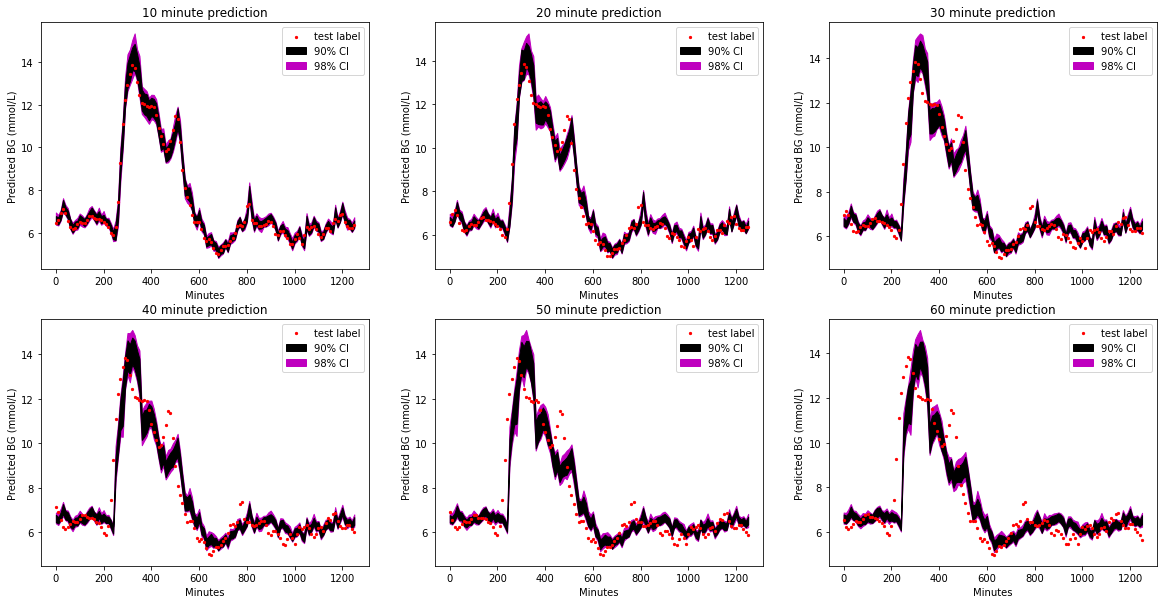

In [ ]:
PH = 6
TIME_HORIZON = 12
RESOLUTION = 10
SAMPLES = 100
BATCH = True

# Load data & model

_, __, test_data, test_label = load_uva(TIME_HORIZON, PH, RESOLUTION, BATCH)

bilstm = tf.keras.models.load_model('saved_models/uva_padova_bilstm.h5', compile=False)
bilstm_ensemble, bilstm_mse, bilstm_pred = sampling(bilstm, test_data, test_label, SAMPLES)

# Construct CI for 10 min prediction

fig, axes = plt.subplots(2,3)
plt.rcParams["figure.figsize"] = (20,10)

bilstm_CI_10mins_90percent = credible_interval(bilstm_pred[:,:,0],alpha=0.1)
bilstm_CI_10mins_98percent = credible_interval(bilstm_pred[:,:,0],alpha=0.02)

axes[0,0].scatter(np.arange(144-TIME_HORIZON-PH)*10, test_label[:144-TIME_HORIZON-PH,0], s=5, c='r', marker='o', label='test label', zorder=10)
axes[0,0].fill_between(np.arange(144-TIME_HORIZON-PH)*10, bilstm_CI_10mins_90percent[:144-TIME_HORIZON-PH,1], bilstm_CI_10mins_90percent[:144-TIME_HORIZON-PH,0], color='k', label='90% CI', zorder=5)
axes[0,0].fill_between(np.arange(144-TIME_HORIZON-PH)*10, bilstm_CI_10mins_98percent[:144-TIME_HORIZON-PH,1],bilstm_CI_10mins_98percent[:144-TIME_HORIZON-PH,0], color='m', label='98% CI', zorder=0)
axes[0,0].set_xlabel('Minutes')
axes[0,0].set_ylabel('Predicted BG (mmol/L)')
axes[0,0].title.set_text('10 minute prediction')
axes[0,0].legend()

# Construct CI for 20 min prediction

bilstm_CI_20mins_90percent = credible_interval(bilstm_pred[:,:,1],alpha=0.1)
bilstm_CI_20mins_98percent = credible_interval(bilstm_pred[:,:,1],alpha=0.02)

axes[0,1].scatter(np.arange(144-TIME_HORIZON-PH)*10, test_label[:144-TIME_HORIZON-PH,1], s=5, c='r', marker='o', label='test label', zorder=10)
axes[0,1].fill_between(np.arange(144-TIME_HORIZON-PH)*10, bilstm_CI_20mins_90percent[:144-TIME_HORIZON-PH,1], bilstm_CI_20mins_90percent[:144-TIME_HORIZON-PH,0], color='k', label='90% CI', zorder=5)
axes[0,1].fill_between(np.arange(144-TIME_HORIZON-PH)*10, bilstm_CI_20mins_98percent[:144-TIME_HORIZON-PH,1],bilstm_CI_20mins_98percent[:144-TIME_HORIZON-PH,0], color='m', label='98% CI', zorder=0)
axes[0,1].set_xlabel('Minutes')
axes[0,1].set_ylabel('Predicted BG (mmol/L)')
axes[0,1].title.set_text('20 minute prediction')
axes[0,1].legend()

# Construct CI for 30 min prediction

bilstm_CI_30mins_90percent = credible_interval(bilstm_pred[:,:,2],alpha=0.1)
bilstm_CI_30mins_98percent = credible_interval(bilstm_pred[:,:,2],alpha=0.02)

axes[0,2].scatter(np.arange(144-TIME_HORIZON-PH)*10, test_label[:144-TIME_HORIZON-PH,2], s=5, c='r', marker='o', label='test label', zorder=10)
axes[0,2].fill_between(np.arange(144-TIME_HORIZON-PH)*10, bilstm_CI_30mins_90percent[:144-TIME_HORIZON-PH,1], bilstm_CI_30mins_90percent[:144-TIME_HORIZON-PH,0], color='k', label='90% CI', zorder=5)
axes[0,2].fill_between(np.arange(144-TIME_HORIZON-PH)*10, bilstm_CI_30mins_98percent[:144-TIME_HORIZON-PH,1], bilstm_CI_30mins_98percent[:144-TIME_HORIZON-PH,0], color='m', label='98% CI', zorder=0)
axes[0,2].set_xlabel('Minutes')
axes[0,2].set_ylabel('Predicted BG (mmol/L)')
axes[0,2].title.set_text('30 minute prediction')
axes[0,2].legend()

# Construct CI for 40 min prediction

bilstm_CI_40mins_90percent = credible_interval(bilstm_pred[:,:,3],alpha=0.1)
bilstm_CI_40mins_98percent = credible_interval(bilstm_pred[:,:,3],alpha=0.02)

axes[1,0].scatter(np.arange(144-TIME_HORIZON-PH)*10, test_label[:144-TIME_HORIZON-PH,3], s=5, c='r', marker='o', label='test label', zorder=10)
axes[1,0].fill_between(np.arange(144-TIME_HORIZON-PH)*10, bilstm_CI_40mins_90percent[:144-TIME_HORIZON-PH,1], bilstm_CI_40mins_90percent[:144-TIME_HORIZON-PH,0], color='k', label='90% CI', zorder=5)
axes[1,0].fill_between(np.arange(144-TIME_HORIZON-PH)*10, bilstm_CI_40mins_98percent[:144-TIME_HORIZON-PH,1], bilstm_CI_40mins_98percent[:144-TIME_HORIZON-PH,0], color='m', label='98% CI', zorder=0)
axes[1,0].set_xlabel('Minutes')
axes[1,0].set_ylabel('Predicted BG (mmol/L)')
axes[1,0].title.set_text('40 minute prediction')
axes[1,0].legend()

# Construct CI for 50 min prediction

bilstm_CI_50mins_90percent = credible_interval(bilstm_pred[:,:,4],alpha=0.1)
bilstm_CI_50mins_98percent = credible_interval(bilstm_pred[:,:,4],alpha=0.02)

axes[1,1].scatter(np.arange(144-TIME_HORIZON-PH)*10, test_label[:144-TIME_HORIZON-PH,4], s=5, c='r', marker='o', label='test label', zorder=10)
axes[1,1].fill_between(np.arange(144-TIME_HORIZON-PH)*10, bilstm_CI_50mins_90percent[:144-TIME_HORIZON-PH,1], bilstm_CI_50mins_90percent[:144-TIME_HORIZON-PH,0], color='k', label='90% CI', zorder=5)
axes[1,1].fill_between(np.arange(144-TIME_HORIZON-PH)*10, bilstm_CI_50mins_98percent[:144-TIME_HORIZON-PH,1], bilstm_CI_50mins_98percent[:144-TIME_HORIZON-PH,0], color='m', label='98% CI', zorder=0)
axes[1,1].set_xlabel('Minutes')
axes[1,1].set_ylabel('Predicted BG (mmol/L)')
axes[1,1].title.set_text('50 minute prediction')
axes[1,1].legend()

# Construct CI for 60 min prediction

bilstm_CI_60mins_90percent = credible_interval(bilstm_pred[:,:,5],alpha=0.1)
bilstm_CI_60mins_98percent = credible_interval(bilstm_pred[:,:,5],alpha=0.02)

axes[1,2].scatter(np.arange(144-TIME_HORIZON-PH)*10, test_label[:144-TIME_HORIZON-PH,5], s=5, c='r', marker='o', label='test label', zorder=10)
axes[1,2].fill_between(np.arange(144-TIME_HORIZON-PH)*10, bilstm_CI_60mins_90percent[:144-TIME_HORIZON-PH,1], bilstm_CI_60mins_90percent[:144-TIME_HORIZON-PH,0], color='k', label='90% CI', zorder=5)
axes[1,2].fill_between(np.arange(144-TIME_HORIZON-PH)*10, bilstm_CI_60mins_98percent[:144-TIME_HORIZON-PH,1], bilstm_CI_60mins_98percent[:144-TIME_HORIZON-PH,0], color='m', label='98% CI', zorder=0)
axes[1,2].set_xlabel('Minutes')
axes[1,2].set_ylabel('Predicted BG (mmol/L)')
axes[1,2].title.set_text('60 minute prediction')
axes[1,2].legend()

#fig.suptitle('Figure 18: Bidirectional LSTM Credible Intervals', fontsize='x-large')
plt.show()

## LSTM


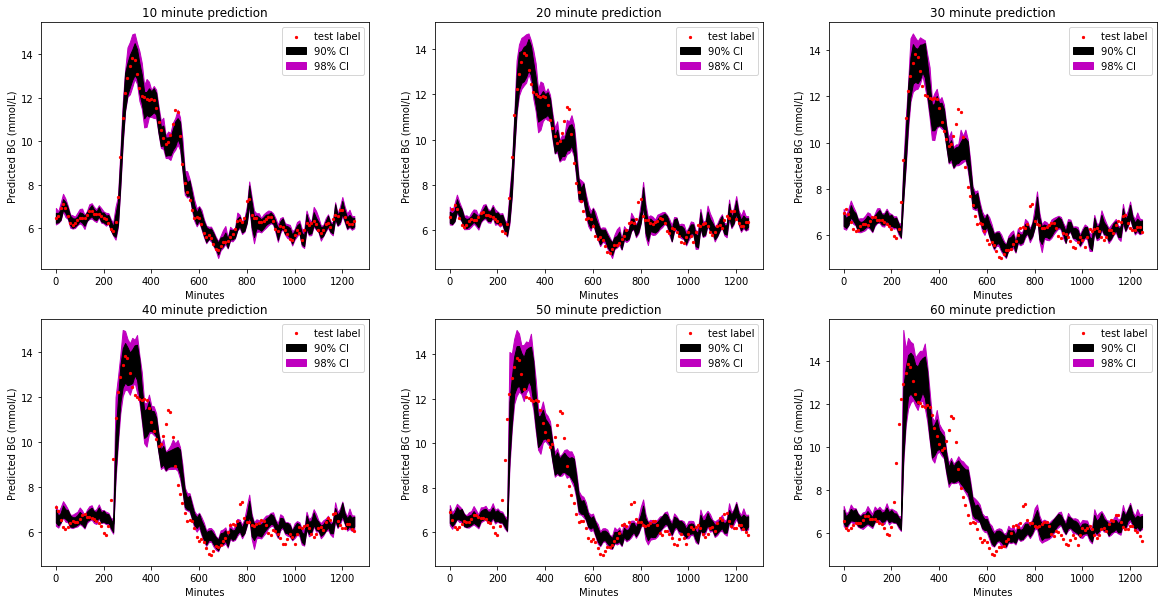

In [ ]:
PH = 6
TIME_HORIZON = 12
RESOLUTION = 10
SAMPLES = 100
BATCH = True

# Load data & model
plt.rcParams["legend.loc"] = 'best'


_, __, test_data, test_label = load_uva(TIME_HORIZON, PH, RESOLUTION, BATCH)

lstm = tf.keras.models.load_model('saved_models/uva_padova_lstm.h5', compile=False)
lstm_ensemble, lstm_mse, lstm_pred = sampling(lstm, test_data, test_label, SAMPLES)

# Construct CI for 10 min prediction

fig, axes = plt.subplots(2,3)
plt.rcParams["figure.figsize"] = (20,10)

lstm_CI_10mins_90percent = credible_interval(lstm_pred[:,:,0],alpha=0.1)
lstm_CI_10mins_98percent = credible_interval(lstm_pred[:,:,0],alpha=0.02)

axes[0,0].scatter(np.arange(144-TIME_HORIZON-PH)*10, test_label[:144-TIME_HORIZON-PH,0], s=5, c='r', marker='o', label='test label', zorder=10)
axes[0,0].fill_between(np.arange(144-TIME_HORIZON-PH)*10, lstm_CI_10mins_90percent[:144-TIME_HORIZON-PH,1], lstm_CI_10mins_90percent[:144-TIME_HORIZON-PH,0], color='k', label='90% CI', zorder=5)
axes[0,0].fill_between(np.arange(144-TIME_HORIZON-PH)*10, lstm_CI_10mins_98percent[:144-TIME_HORIZON-PH,1], lstm_CI_10mins_98percent[:144-TIME_HORIZON-PH,0], color='m', label='98% CI', zorder=0)
axes[0,0].set_xlabel('Minutes')
axes[0,0].set_ylabel('Predicted BG (mmol/L)')
axes[0,0].title.set_text('10 minute prediction')
axes[0,0].legend()

# Construct CI for 20 min prediction

lstm_CI_20mins_90percent = credible_interval(lstm_pred[:,:,1],alpha=0.1)
lstm_CI_20mins_98percent = credible_interval(lstm_pred[:,:,1],alpha=0.02)

axes[0,1].scatter(np.arange(144-TIME_HORIZON-PH)*10, test_label[:144-TIME_HORIZON-PH,1], s=5, c='r', marker='o', label='test label', zorder=10)
axes[0,1].fill_between(np.arange(144-TIME_HORIZON-PH)*10, lstm_CI_20mins_90percent[:144-TIME_HORIZON-PH,1], lstm_CI_20mins_90percent[:144-TIME_HORIZON-PH,0], color='k', label='90% CI', zorder=5)
axes[0,1].fill_between(np.arange(144-TIME_HORIZON-PH)*10, lstm_CI_20mins_98percent[:144-TIME_HORIZON-PH,1], lstm_CI_20mins_98percent[:144-TIME_HORIZON-PH,0], color='m', label='98% CI', zorder=0)
axes[0,1].set_xlabel('Minutes')
axes[0,1].set_ylabel('Predicted BG (mmol/L)')
axes[0,1].title.set_text('20 minute prediction')
axes[0,1].legend()

# Construct CI for 30 min prediction

lstm_CI_30mins_90percent = credible_interval(lstm_pred[:,:,2],alpha=0.1)
lstm_CI_30mins_98percent = credible_interval(lstm_pred[:,:,2],alpha=0.02)

axes[0,2].scatter(np.arange(144-TIME_HORIZON-PH)*10, test_label[:144-TIME_HORIZON-PH,2], s=5, c='r', marker='o', label='test label', zorder=10)
axes[0,2].fill_between(np.arange(144-TIME_HORIZON-PH)*10, lstm_CI_30mins_90percent[:144-TIME_HORIZON-PH,1], lstm_CI_30mins_90percent[:144-TIME_HORIZON-PH,0], color='k', label='90% CI', zorder=5)
axes[0,2].fill_between(np.arange(144-TIME_HORIZON-PH)*10, lstm_CI_30mins_98percent[:144-TIME_HORIZON-PH,1], lstm_CI_30mins_98percent[:144-TIME_HORIZON-PH,0], color='m', label='98% CI', zorder=0)
axes[0,2].set_xlabel('Minutes')
axes[0,2].set_ylabel('Predicted BG (mmol/L)')
axes[0,2].title.set_text('30 minute prediction')
axes[0,2].legend()

# Construct CI for 40 min prediction

lstm_CI_40mins_90percent = credible_interval(lstm_pred[:,:,3],alpha=0.1)
lstm_CI_40mins_98percent = credible_interval(lstm_pred[:,:,3],alpha=0.02)

axes[1,0].scatter(np.arange(144-TIME_HORIZON-PH)*10, test_label[:144-TIME_HORIZON-PH,3], s=5, c='r', marker='o', label='test label', zorder=10)
axes[1,0].fill_between(np.arange(144-TIME_HORIZON-PH)*10, lstm_CI_40mins_90percent[:144-TIME_HORIZON-PH,1], lstm_CI_40mins_90percent[:144-TIME_HORIZON-PH,0], color='k', label='90% CI', zorder=5)
axes[1,0].fill_between(np.arange(144-TIME_HORIZON-PH)*10, lstm_CI_40mins_98percent[:144-TIME_HORIZON-PH,1], lstm_CI_40mins_98percent[:144-TIME_HORIZON-PH,0], color='m', label='98% CI', zorder=0)
axes[1,0].set_xlabel('Minutes')
axes[1,0].set_ylabel('Predicted BG (mmol/L)')
axes[1,0].title.set_text('40 minute prediction')
axes[1,0].legend()

# Construct CI for 50 min prediction

lstm_CI_50mins_90percent = credible_interval(lstm_pred[:,:,4],alpha=0.1)
lstm_CI_50mins_98percent = credible_interval(lstm_pred[:,:,4],alpha=0.02)

axes[1,1].scatter(np.arange(144-TIME_HORIZON-PH)*10, test_label[:144-TIME_HORIZON-PH,4], s=5, c='r', marker='o', label='test label', zorder=10)
axes[1,1].fill_between(np.arange(144-TIME_HORIZON-PH)*10, lstm_CI_50mins_90percent[:144-TIME_HORIZON-PH,1], lstm_CI_50mins_90percent[:144-TIME_HORIZON-PH,0], color='k', label='90% CI', zorder=5)
axes[1,1].fill_between(np.arange(144-TIME_HORIZON-PH)*10, lstm_CI_50mins_98percent[:144-TIME_HORIZON-PH,1], lstm_CI_50mins_98percent[:144-TIME_HORIZON-PH,0], color='m', label='98% CI', zorder=0)
axes[1,1].set_xlabel('Minutes')
axes[1,1].set_ylabel('Predicted BG (mmol/L)')
axes[1,1].title.set_text('50 minute prediction')
axes[1,1].legend()

# Construct CI for 60 min prediction

lstm_CI_60mins_90percent = credible_interval(lstm_pred[:,:,5],alpha=0.1)
lstm_CI_60mins_98percent = credible_interval(lstm_pred[:,:,5],alpha=0.02)

axes[1,2].scatter(np.arange(144-TIME_HORIZON-PH)*10, test_label[:144-TIME_HORIZON-PH,5], s=5, c='r', marker='o', label='test label', zorder=10)
axes[1,2].fill_between(np.arange(144-TIME_HORIZON-PH)*10, lstm_CI_60mins_90percent[:144-TIME_HORIZON-PH,1], lstm_CI_60mins_90percent[:144-TIME_HORIZON-PH,0], color='k', label='90% CI', zorder=5)
axes[1,2].fill_between(np.arange(144-TIME_HORIZON-PH)*10, lstm_CI_60mins_98percent[:144-TIME_HORIZON-PH,1], lstm_CI_60mins_98percent[:144-TIME_HORIZON-PH,0], color='m', label='98% CI', zorder=0)
axes[1,2].set_xlabel('Minutes')
axes[1,2].set_ylabel('Predicted BG (mmol/L)')
axes[1,2].title.set_text('60 minute prediction')
axes[1,2].legend()

#fig.suptitle('Figure 13: LSTM Credible Intervals', fontsize='x-large')
plt.show()

## CRNN

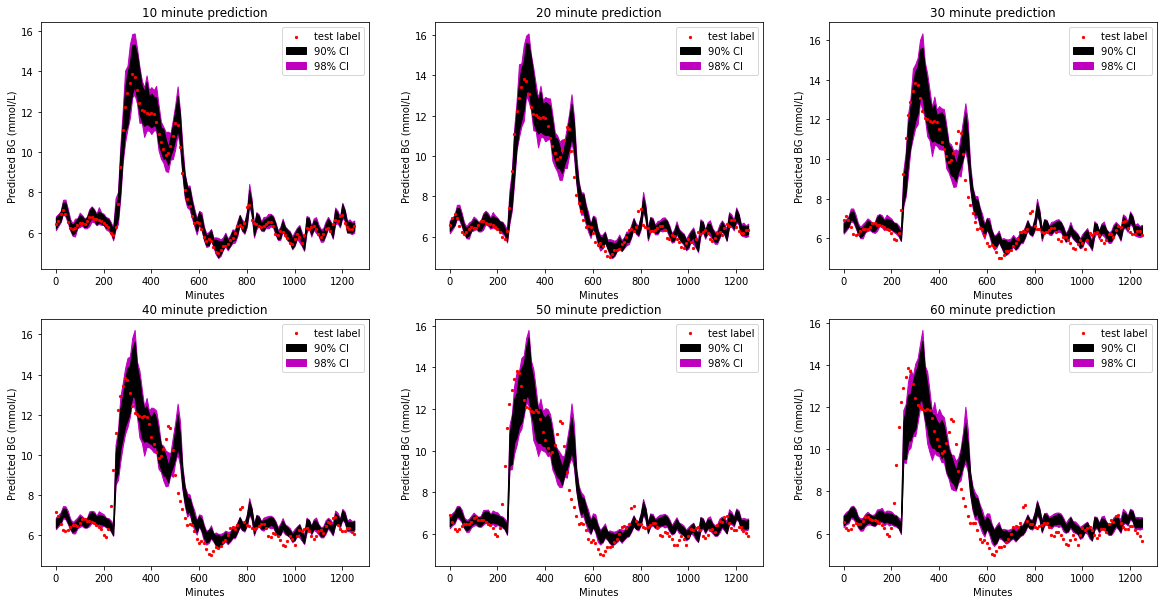

In [ ]:
PH = 6
TIME_HORIZON = 12
RESOLUTION = 10
SAMPLES = 100
BATCH = True

# Load data & model

_, __, test_data, test_label = load_uva(TIME_HORIZON, PH, RESOLUTION, BATCH)

crnn = tf.keras.models.load_model('saved_models/uva_padova_crnn.h5', compile=False)
crnn_ensemble, crnn_mse, crnn_pred = sampling(crnn, test_data, test_label, SAMPLES)

# Construct CI for 10 min prediction

fig, axes = plt.subplots(2,3)
plt.rcParams["figure.figsize"] = (20,10)

crnn_CI_10mins_90percent = credible_interval(crnn_pred[:,:,0],alpha=0.1)
crnn_CI_10mins_98percent = credible_interval(crnn_pred[:,:,0],alpha=0.02)

axes[0,0].scatter(np.arange(144-TIME_HORIZON-PH)*10, test_label[:144-TIME_HORIZON-PH,0], s=5, c='r', marker='o', label='test label', zorder=10)
axes[0,0].fill_between(np.arange(144-TIME_HORIZON-PH)*10, crnn_CI_10mins_90percent[:144-TIME_HORIZON-PH,1], crnn_CI_10mins_90percent[:144-TIME_HORIZON-PH,0], color='k', label='90% CI', zorder=5)
axes[0,0].fill_between(np.arange(144-TIME_HORIZON-PH)*10, crnn_CI_10mins_98percent[:144-TIME_HORIZON-PH,1], crnn_CI_10mins_98percent[:144-TIME_HORIZON-PH,0], color='m', label='98% CI', zorder=0)
axes[0,0].set_xlabel('Minutes')
axes[0,0].set_ylabel('Predicted BG (mmol/L)')
axes[0,0].title.set_text('10 minute prediction')
axes[0,0].legend()

# Construct CI for 20 min prediction

crnn_CI_20mins_90percent = credible_interval(crnn_pred[:,:,1],alpha=0.1)
crnn_CI_20mins_98percent = credible_interval(crnn_pred[:,:,1],alpha=0.02)

axes[0,1].scatter(np.arange(144-TIME_HORIZON-PH)*10, test_label[:144-TIME_HORIZON-PH,1], s=5, c='r', marker='o', label='test label', zorder=10)
axes[0,1].fill_between(np.arange(144-TIME_HORIZON-PH)*10, crnn_CI_20mins_90percent[:144-TIME_HORIZON-PH,1], crnn_CI_20mins_90percent[:144-TIME_HORIZON-PH,0], color='k', label='90% CI', zorder=5)
axes[0,1].fill_between(np.arange(144-TIME_HORIZON-PH)*10, crnn_CI_20mins_98percent[:144-TIME_HORIZON-PH,1], crnn_CI_20mins_98percent[:144-TIME_HORIZON-PH,0], color='m', label='98% CI', zorder=0)
axes[0,1].set_xlabel('Minutes')
axes[0,1].set_ylabel('Predicted BG (mmol/L)')
axes[0,1].title.set_text('20 minute prediction')
axes[0,1].legend()

# Construct CI for 30 min prediction

crnn_CI_30mins_90percent = credible_interval(crnn_pred[:,:,2],alpha=0.1)
crnn_CI_30mins_98percent = credible_interval(crnn_pred[:,:,2],alpha=0.02)

axes[0,2].scatter(np.arange(144-TIME_HORIZON-PH)*10, test_label[:144-TIME_HORIZON-PH,2], s=5, c='r', marker='o', label='test label', zorder=10)
axes[0,2].fill_between(np.arange(144-TIME_HORIZON-PH)*10, crnn_CI_30mins_90percent[:144-TIME_HORIZON-PH,1], crnn_CI_30mins_90percent[:144-TIME_HORIZON-PH,0], color='k', label='90% CI', zorder=5)
axes[0,2].fill_between(np.arange(144-TIME_HORIZON-PH)*10, crnn_CI_30mins_98percent[:144-TIME_HORIZON-PH,1], crnn_CI_30mins_98percent[:144-TIME_HORIZON-PH,0], color='m', label='98% CI', zorder=0)
axes[0,2].set_xlabel('Minutes')
axes[0,2].set_ylabel('Predicted BG (mmol/L)')
axes[0,2].title.set_text('30 minute prediction')
axes[0,2].legend()

# Construct CI for 40 min prediction

crnn_CI_40mins_90percent = credible_interval(crnn_pred[:,:,3],alpha=0.1)
crnn_CI_40mins_98percent = credible_interval(crnn_pred[:,:,3],alpha=0.02)

axes[1,0].scatter(np.arange(144-TIME_HORIZON-PH)*10, test_label[:144-TIME_HORIZON-PH,3], s=5, c='r', marker='o', label='test label', zorder=10)
axes[1,0].fill_between(np.arange(144-TIME_HORIZON-PH)*10, crnn_CI_40mins_90percent[:144-TIME_HORIZON-PH,1], crnn_CI_40mins_90percent[:144-TIME_HORIZON-PH,0], color='k', label='90% CI', zorder=5)
axes[1,0].fill_between(np.arange(144-TIME_HORIZON-PH)*10, crnn_CI_40mins_98percent[:144-TIME_HORIZON-PH,1], crnn_CI_40mins_98percent[:144-TIME_HORIZON-PH,0], color='m', label='98% CI', zorder=0)
axes[1,0].set_xlabel('Minutes')
axes[1,0].set_ylabel('Predicted BG (mmol/L)')
axes[1,0].title.set_text('40 minute prediction')
axes[1,0].legend()

# Construct CI for 50 min prediction

crnn_CI_50mins_90percent = credible_interval(crnn_pred[:,:,4],alpha=0.1)
crnn_CI_50mins_98percent = credible_interval(crnn_pred[:,:,4],alpha=0.02)

axes[1,1].scatter(np.arange(144-TIME_HORIZON-PH)*10, test_label[:144-TIME_HORIZON-PH,4], s=5, c='r', marker='o', label='test label', zorder=10)
axes[1,1].fill_between(np.arange(144-TIME_HORIZON-PH)*10, crnn_CI_50mins_90percent[:144-TIME_HORIZON-PH,1], crnn_CI_50mins_90percent[:144-TIME_HORIZON-PH,0], color='k', label='90% CI', zorder=5)
axes[1,1].fill_between(np.arange(144-TIME_HORIZON-PH)*10, crnn_CI_50mins_98percent[:144-TIME_HORIZON-PH,1], crnn_CI_50mins_98percent[:144-TIME_HORIZON-PH,0], color='m', label='98% CI', zorder=0)
axes[1,1].set_xlabel('Minutes')
axes[1,1].set_ylabel('Predicted BG (mmol/L)')
axes[1,1].title.set_text('50 minute prediction')
axes[1,1].legend()

# Construct CI for 60 min prediction

crnn_CI_60mins_90percent = credible_interval(crnn_pred[:,:,5],alpha=0.1)
crnn_CI_60mins_98percent = credible_interval(crnn_pred[:,:,5],alpha=0.02)

axes[1,2].scatter(np.arange(144-TIME_HORIZON-PH)*10, test_label[:144-TIME_HORIZON-PH,5], s=5, c='r', marker='o', label='test label', zorder=10)
axes[1,2].fill_between(np.arange(144-TIME_HORIZON-PH)*10, crnn_CI_60mins_90percent[:144-TIME_HORIZON-PH,1], crnn_CI_60mins_90percent[:144-TIME_HORIZON-PH,0], color='k', label='90% CI', zorder=5)
axes[1,2].fill_between(np.arange(144-TIME_HORIZON-PH)*10, crnn_CI_60mins_98percent[:144-TIME_HORIZON-PH,1], crnn_CI_60mins_98percent[:144-TIME_HORIZON-PH,0], color='m', label='98% CI', zorder=0)
axes[1,2].set_xlabel('Minutes')
axes[1,2].set_ylabel('Predicted BG (mmol/L)')
axes[1,2].title.set_text('60 minute prediction')
axes[1,2].legend()

#fig.suptitle('Figure 14: CRNN Credible Intervals', fontsize='x-large')
plt.show()

## Average results

In [ ]:
PH = 6
TIME_HORIZON = 12
RESOLUTION = 10
SAMPLES = 100
BATCH = True

# Load data & model

_, __, test_data, test_label = load_uva(TIME_HORIZON, PH, RESOLUTION, BATCH)

bilstm = tf.keras.models.load_model('saved_models/uva_padova_bilstm.h5', compile=False)
bilstm_ensemble, bilstm_mse, bilstm_pred = sampling(bilstm, test_data, test_label, SAMPLES)

lstm = tf.keras.models.load_model('saved_models/uva_padova_lstm.h5', compile=False)
lstm_ensemble, lstm_mse, lstm_pred = sampling(lstm, test_data, test_label, SAMPLES)

crnn = tf.keras.models.load_model('saved_models/uva_padova_crnn.h5', compile=False)
crnn_ensemble, crnn_mse, crnn_pred = sampling(crnn, test_data, test_label, SAMPLES)

bilstm_CI_10mins_90percent = credible_interval(bilstm_pred[:,:,0],alpha=0.1)
bilstm_CI_10mins_98percent = credible_interval(bilstm_pred[:,:,0],alpha=0.02)

crnn_CI_10mins_90percent = credible_interval(crnn_pred[:,:,0],alpha=0.1)
crnn_CI_10mins_98percent = credible_interval(crnn_pred[:,:,0],alpha=0.02)

lstm_CI_10mins_90percent = credible_interval(lstm_pred[:,:,0],alpha=0.1)
lstm_CI_10mins_98percent = credible_interval(lstm_pred[:,:,0],alpha=0.02)

print(np.mean(np.subtract(bilstm_CI_10mins_90percent[:,1], bilstm_CI_10mins_90percent[:,0])))
print(np.mean(np.subtract(bilstm_CI_10mins_98percent[:,1], bilstm_CI_10mins_98percent[:,0])))

print(np.mean(np.subtract(lstm_CI_10mins_90percent[:,1], lstm_CI_10mins_90percent[:,0])))
print(np.mean(np.subtract(lstm_CI_10mins_98percent[:,1], lstm_CI_10mins_98percent[:,0])))

print(np.mean(np.subtract(crnn_CI_10mins_90percent[:,1], crnn_CI_10mins_90percent[:,0])))
print(np.mean(np.subtract(crnn_CI_10mins_98percent[:,1], crnn_CI_10mins_98percent[:,0])))


0.45340273950618676
0.6450622175029213
0.5858810984287504
0.837628634403737
0.648220709736041
0.9330938790726397


# Ensembling

(756, 3, 144)


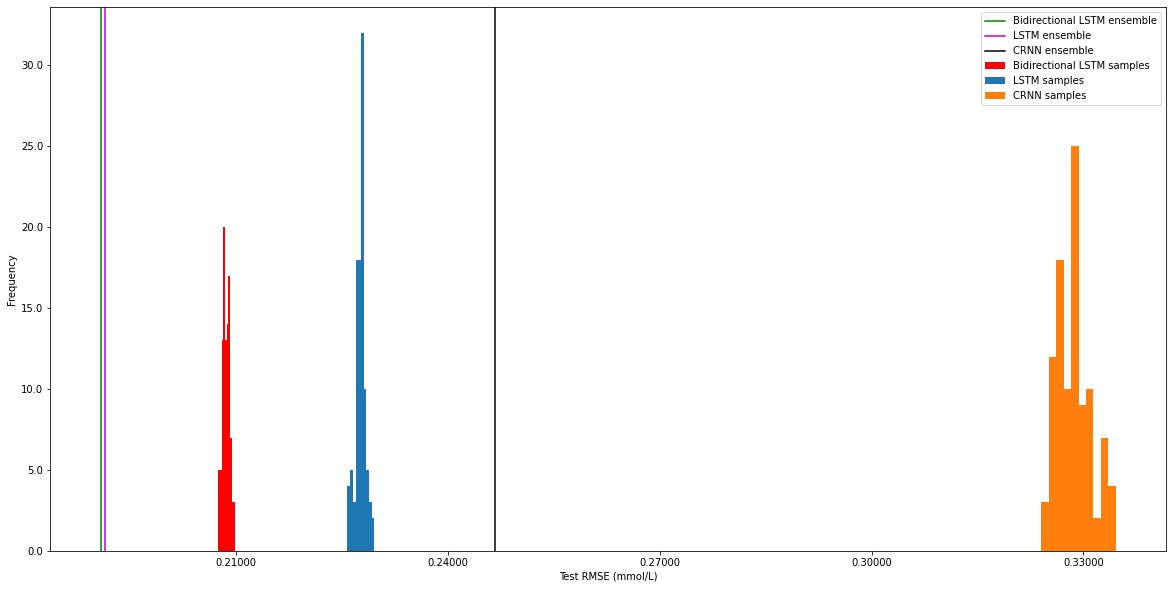

In [ ]:
PH = 6
TIME_HORIZON = 12
RESOLUTION = 10
SAMPLES = 100
BATCH = True
plt.rcParams["legend.loc"] = 'upper right'

_, __, test_data, test_label = load_mpc(TIME_HORIZON, PH, RESOLUTION, BATCH)

bilstm = tf.keras.models.load_model('saved_models/mpc_guided_bilstm.h5', compile=False)
mc_bilstm_ensemble, mc_bilstm_mse, mc_bilstm_pred = sampling(bilstm, test_data, test_label, SAMPLES)

lstm = tf.keras.models.load_model('saved_models/mpc_guided_lstm.h5', compile=False)
mc_lstm_ensemble, mc_lstm_mse, mc_lstm_pred = sampling(lstm, test_data, test_label, SAMPLES)

crnn = tf.keras.models.load_model('saved_models/mpc_guided_crnn.h5', compile=False)
mc_crnn_ensemble, mc_crnn_mse, mc_crnn_pred = sampling(crnn, test_data, test_label, SAMPLES)


#print(mc_bilstm_ensemble, mc_bilstm_mse, mc_bilstm_pred)
# Plots

plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams["legend.loc"] = 'upper right'
fig, ax = plt.subplots()
ax.hist(np.sqrt(mc_bilstm_mse), color='r', label='Bidirectional LSTM samples')
ax.hist(np.sqrt(mc_lstm_mse), label='LSTM samples')
ax.hist(np.sqrt(mc_crnn_mse), label='CRNN samples')
ax.axvline(x=mc_bilstm_ensemble**(1/2), color='g', label='Bidirectional LSTM ensemble')
ax.axvline(x=mc_lstm_ensemble**(1/2), color='m', label='LSTM ensemble')
ax.axvline(x=mc_crnn_ensemble**(1/2), color='k', label='CRNN ensemble')
ax.xaxis.set_major_locator(tick.MaxNLocator(6))
ax.xaxis.set_major_formatter(tick.FormatStrFormatter('%.5f'))
ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%1.1f'))
ax.set_xlabel('Test RMSE (mmol/L)')
ax.set_ylabel('Frequency')
#plt.title('Figure 19. MPC ensemble results')
plt.legend()

plt.show()

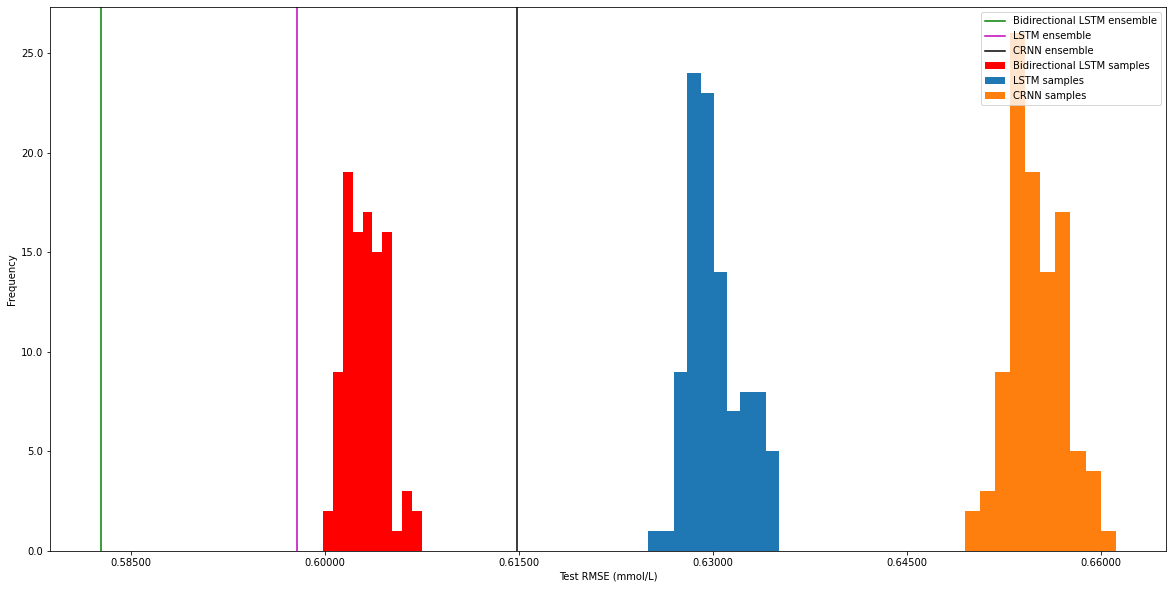

In [ ]:
PH = 6
TIME_HORIZON = 12
RESOLUTION = 10
SAMPLES = 100
BATCH = True
plt.rcParams["legend.loc"] = 'upper right'

_, __, test_data, test_label = load_uva(TIME_HORIZON, PH, RESOLUTION, BATCH)

bilstm = tf.keras.models.load_model('saved_models/uva_padova_bilstm.h5', compile=False)
mc_bilstm_ensemble, mc_bilstm_mse, mc_bilstm_pred = sampling(bilstm, test_data, test_label, SAMPLES)

lstm = tf.keras.models.load_model('saved_models/uva_padova_lstm.h5', compile=False)
mc_lstm_ensemble, mc_lstm_mse, mc_lstm_pred = sampling(lstm, test_data, test_label, SAMPLES)

crnn = tf.keras.models.load_model('saved_models/uva_padova_crnn.h5', compile=False)
mc_crnn_ensemble, mc_crnn_mse, mc_crnn_pred = sampling(crnn, test_data, test_label, SAMPLES)


#print(mc_bilstm_ensemble, mc_bilstm_mse, mc_bilstm_pred)
# Plots

plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams["legend.loc"] = 'upper right'
fig, ax = plt.subplots()
ax.hist(np.sqrt(mc_bilstm_mse), color='r', label='Bidirectional LSTM samples')
ax.hist(np.sqrt(mc_lstm_mse), label='LSTM samples')
ax.hist(np.sqrt(mc_crnn_mse), label='CRNN samples')
ax.axvline(x=mc_bilstm_ensemble**(1/2), color='g', label='Bidirectional LSTM ensemble')
ax.axvline(x=mc_lstm_ensemble**(1/2), color='m', label='LSTM ensemble')
ax.axvline(x=mc_crnn_ensemble**(1/2), color='k', label='CRNN ensemble')
ax.xaxis.set_major_locator(tick.MaxNLocator(6))
ax.xaxis.set_major_formatter(tick.FormatStrFormatter('%.5f'))
ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%1.1f'))
ax.set_xlabel('Test RMSE (mmol/L)')
ax.set_ylabel('Frequency')
#plt.title('Figure 20. UVA Padova ensemble results')
plt.legend()

plt.show()